# Random forest: Titanic


In [90]:
# Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV



In [2]:
url='https://raw.githubusercontent.com/4GeeksAcademy/random-forest-project-tutorial/main/titanic_train.csv'
df_raw = pd.read_csv(url)

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [7]:
df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
219,220,0,2,"Harris, Mr. Walter",male,30.0,0,0,W/C 14208,10.5000,NaN,S
865,866,1,2,"Bystrom, Mrs. (Karolina)",female,42.0,0,0,236852,13.0000,NaN,S
729,730,0,3,"Ilmakangas, Miss. Pieta Sofia",female,25.0,1,0,STON/O2. 3101271,7.9250,NaN,S
419,420,0,3,"Van Impe, Miss. Catharina",female,10.0,0,2,345773,24.1500,NaN,S
832,833,0,3,"Saad, Mr. Amin",male,NaN,0,0,2671,7.2292,NaN,C
317,318,0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S
284,285,0,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.0000,A19,S
104,105,0,3,"Gustafsson, Mr. Anders Vilhelm",male,37.0,2,0,3101276,7.9250,NaN,S
562,563,0,2,"Norman, Mr. Robert Douglas",male,28.0,0,0,218629,13.5000,NaN,S
496,497,1,1,"Eustis, Miss. Elizabeth Mussey",female,54.0,1,0,36947,78.2667,D20,C


In [47]:
df = df_raw.copy()

Check if there are duplicated passengers

In [12]:
df_duplicates = df['PassengerId'].duplicated().sum()

print(f'It seems that there are {df_duplicates} duplicated passenger according to the PassengerId feature.')

It seems that there are 0 duplicated passenger according to the PassengerId feature


Drop irrelevant columns

In [48]:
drop_cols = ['PassengerId','Cabin', 'Ticket', 'Name']
df = df.drop(drop_cols, axis = 1)

Fill missing values

In [49]:
# Age by sex
df.groupby('Sex')['Age'].describe()

# The mean age is different for male and female --> fill missing values of age with the median of the sex

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,261.0,27.915709,14.110146,0.75,18.0,27.0,37.0,63.0
male,453.0,30.726645,14.678201,0.42,21.0,29.0,39.0,80.0


In [50]:
# Fill missing values of age with mean by sex
#  
df.loc[df['Sex']=='female','Age']=df[(df['Sex']=='female')].fillna(df.loc[df['Sex']=='female','Age'].mean())

df.loc[df['Sex']=='male','Age']=df[(df['Sex']=='male')].fillna(df.loc[df['Sex']=='male','Age'].mean())

In [51]:
# Fill missing values of Embarked with mode

df['Embarked']=df['Embarked'].fillna(df['Embarked'].mode()[0])

In [52]:
# The are not null values

df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Encoding categorical variables

In [53]:
# Change type of variables 

df[['Sex','Embarked']]=df[['Sex','Embarked']].astype('category')

In [54]:
# Encoding

df['Sex']=df['Sex'].cat.codes

df['Embarked']=df['Embarked'].cat.codes

In [34]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


## Start modeling

In [56]:
# Train, test datasets

X = df.drop('Survived', axis=1)

y= df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1107)

In [57]:
y.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

### 1. Random forest with default hyperparameters

In [58]:
rfc1 = RandomForestClassifier(random_state=1107)

rfc1.fit(X_train, y_train)

y_pred = rfc1.predict(X_test)

In [59]:
print('Accuracy Random Forest with default parameters:',rfc1.score(X_test, y_test))

Accuracy Random Forest with default parameters: 0.8251121076233184


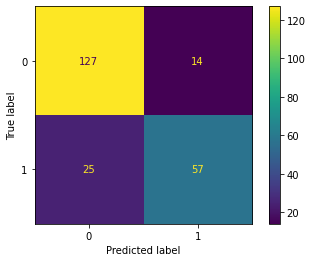

In [60]:
cm = confusion_matrix(y_test, y_pred, labels=rfc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=rfc1.classes_)
disp.plot()

plt.show()

In [61]:
print(classification_report(y_test,y_pred))

# 90% of the true non-survivers were predicted correctly (recall of class 0)
# 84% of the 0 predictions were correct

# If i had predicted that all the passengers died, the accuracy would have been 0.63 (141/(141+82))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       141
           1       0.80      0.70      0.75        82

    accuracy                           0.83       223
   macro avg       0.82      0.80      0.81       223
weighted avg       0.82      0.83      0.82       223



### 2. Optimize model hyperparameters to select the better forest

2.1 Grid Search CV (tries with all the possible combinations)

In [63]:
param_grid = [{'max_depth': [8, 12, 16], 
         'min_samples_split': [12, 16, 20], 
         'criterion': ['gini', 'entropy']}]

print(param_grid)

[{'max_depth': [8, 12, 16], 'min_samples_split': [12, 16, 20], 'criterion': ['gini', 'entropy']}]


In [68]:
rfc2=RandomForestClassifier(random_state=1107)

grid=GridSearchCV(estimator=rfc2,param_grid=param_grid, cv=5, n_jobs=-1,verbose=2)

grid.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..criterion=gini, max_depth=8, min_samples_split=20; total time=   0.3s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=16; total time=   0.3s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.3s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.4s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=16; total time=   0.4s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.4s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=16; total time=   0.4s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=16; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=16; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samp

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1107),
             n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [8, 12, 16],
                          'min_samples_split': [12, 16, 20]}],
             verbose=2)

In [69]:
print('Best parameters:', grid.best_params_) 

Best parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 20}


In [72]:
# to see the results
grid.best_estimator_

# save it into model_cv
model_cv=grid.best_estimator_

In [73]:
y_pred_cv = model_cv.predict(X_test)

print('Accuracy of random forest selected by CV in test set (grid search):',np.mean(y_test==y_pred_cv))

Accuracy of random foresct selected by CV in test set: 0.8385650224215246


In [74]:
# Another way to calculate the accuracy (more direct)

print('Accuracy of random forest selected by CV in test set (grid search):',grid.score(X_test, y_test))

Accuracy of random foresct selected by CV in test set: 0.8385650224215246


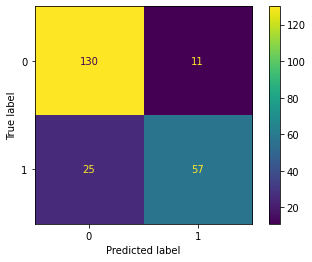

In [75]:
cm = confusion_matrix(y_test, y_pred_cv, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=grid.classes_)
disp.plot()

plt.show()

In [76]:
print(classification_report(y_test,y_pred_cv))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       141
           1       0.84      0.70      0.76        82

    accuracy                           0.84       223
   macro avg       0.84      0.81      0.82       223
weighted avg       0.84      0.84      0.83       223



Feature importance

Feature: 0, Score: 0.13994
Feature: 1, Score: 0.41014
Feature: 2, Score: 0.15364
Feature: 3, Score: 0.04853
Feature: 4, Score: 0.03233
Feature: 5, Score: 0.17961
Feature: 6, Score: 0.03581


/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


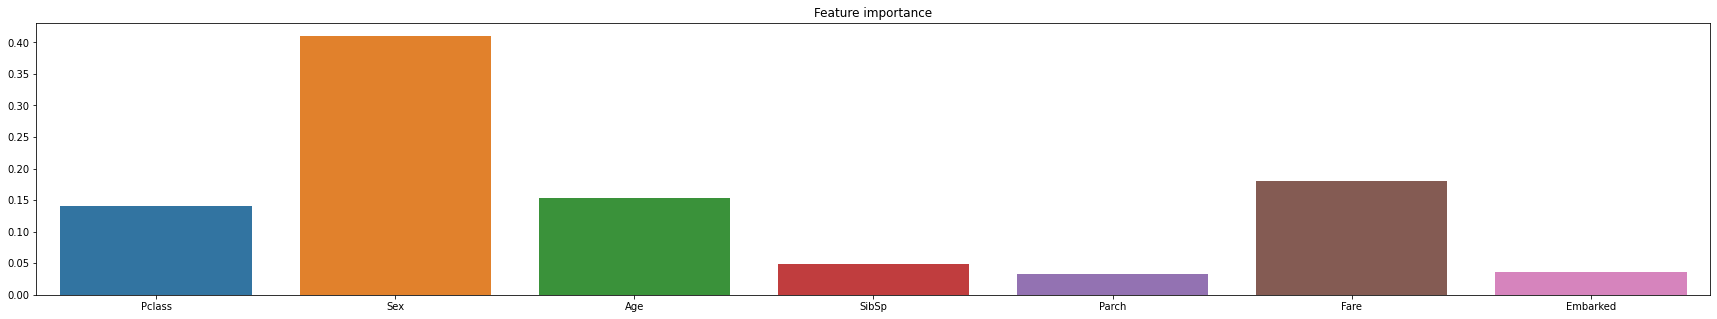

In [89]:
importance = model_cv.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# graficamos la importancia de las variables

plt.figure(figsize=(30,5))
columns = X.columns
sns.barplot(columns, importance)
plt.title('Feature importance')
plt.show()

2.2 Randomized search CV

In this case, not all parameters values are tried out. This allows us to include more hyperparameters in the grid

In [91]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Criterio
criterion=['gini','entropy']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
#'max_features': max_features, # Son muy pocas variables por lo cual no vale la pena aplicarlo
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap,
'criterion':criterion}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [95]:
rfc3=RandomForestClassifier(random_state=1107)

grid_random=RandomizedSearchCV(estimator=rfc3,n_iter=100,cv=5,random_state=1107,param_distributions=random_grid)
# n_iter: number of parameter settings that are sampled

In [96]:
grid_random.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1107),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1107)

In [97]:
print('Best parameters:', grid_random.best_params_) 

Best parameters: {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 40, 'criterion': 'gini', 'bootstrap': True}


In [98]:
print('Best model:', grid_random.best_estimator_) 

Best model: RandomForestClassifier(max_depth=40, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=2000, random_state=1107)


In [99]:
# Save best model
model_cv_2 = grid_random.best_estimator_

In [100]:
# Accuracy in test data - option 1
y_pred_cv_2 = model_cv_2.predict(X_test)

print('Accuracy of random forest selected by CV in test set (random grid search):',np.mean(y_test==y_pred_cv_2))

Accuracy of random forest selected by CV in test set (random grid search): 0.8430493273542601


In [101]:
# Accuracy in test data - option 2

print('Accuracy of random forest selected by CV in test set (random grid search):',grid_random.score(X_test, y_test))

Accuracy of random forest selected by CV in test set (random grid search): 0.8430493273542601


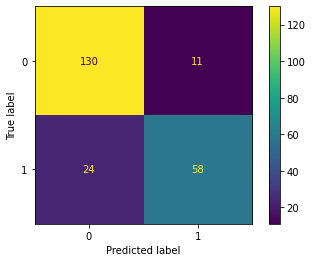

In [103]:
cm = confusion_matrix(y_test, y_pred_cv_2, labels=grid_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=grid_random.classes_)
disp.plot()

plt.show()

In [104]:
print(classification_report(y_test,y_pred_cv_2))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       141
           1       0.84      0.71      0.77        82

    accuracy                           0.84       223
   macro avg       0.84      0.81      0.82       223
weighted avg       0.84      0.84      0.84       223



Feature importance

Feature: 0, Score: 0.10961
Feature: 1, Score: 0.32921
Feature: 2, Score: 0.20026
Feature: 3, Score: 0.05201
Feature: 4, Score: 0.03529
Feature: 5, Score: 0.23613
Feature: 6, Score: 0.03749


/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


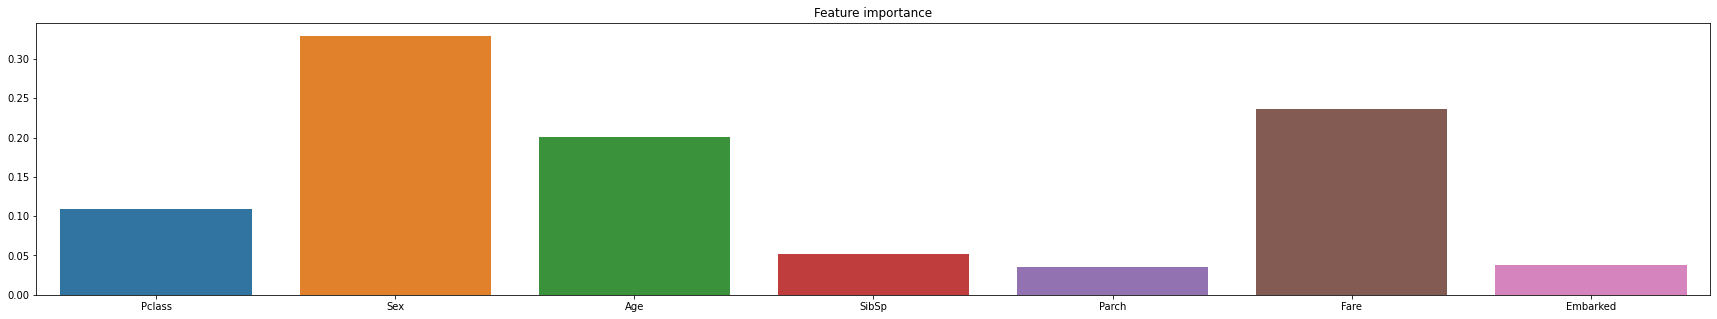

In [102]:
importance = model_cv_2.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# graficamos la importancia de las variables

plt.figure(figsize=(30,5))
columns = X.columns
sns.barplot(columns, importance)
plt.title('Feature importance')
plt.show()

- In both forests selected by cross-validation (one with grid search and the other one with random grid search) the most important features are: sex, age, fare and pclass
- The performance of the model in the test dataset did not improve sustantially between the random forest with hyperparameters chosen by grid search and the random forest with hyperparameters chosen by random grid search (and this one took more time because we included more hyperparameters in the search)

In [107]:
# Save best model

filename = '../models/final_model.sav'
pickle.dump(model_cv_2, open(filename, 'wb'))